In [58]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, balanced_accuracy_score
from metrics import acc

from data import get_training_and_validation_data
from autoencoder import Autoencoder, VariationalAutoencoder, CategoricalAutoencoder

model_id = 'Z4CVDXGLEL'
model_config = json.load(open(Path('models') / model_id / 'config.json', 'r'))
dataset_id = model_config['dataset_id']
model_type = model_config['model']

X_train, y_train, X_val, y_val = get_training_and_validation_data(
    Path('processed_data'), dataset_id, balanced=True)
# X_mean, X_std = X_train.mean(), X_train.std()
# X_train -= X_mean
# X_train /= X_std
# X_val -= X_mean
# X_val /= X_std

X_min, X_max = X_train.min(), X_train.max()
X_train -= X_min
X_train /= (X_max - X_min)
X_val -= X_min
X_val /= (X_max - X_min)
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
X_val_tensor = torch.from_numpy(X_val).to(torch.float32)

if model_config['model'] == 'vae':
    model = VariationalAutoencoder
elif model_config['model'] == 'cae':
    model = CategoricalAutoencoder
else:
    model = Autoencoder

autoencoder = model(
    input_dim=X_train.shape[1],
    hidden_dims=[model_config['l1'], model_config['l2']],
    latent_dim=model_config['latent_dim'],
    activation=model_config['activation'],
    latent_activation=model_config['latent_activation'],
    negative_slope=model_config['negative_slope']
)
autoencoder.load_state_dict(torch.load(Path('models') / model_id / 'ae.pth'))
autoencoder.eval()

if model_type != 'vae':
    X_train_enc = autoencoder.encoder(X_train_tensor)
else:
    X_train_mu, X_train_log = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(X_train_mu, X_train_log)
X_train_rec = autoencoder.decoder(X_train_enc).detach().numpy()
X_train_enc = X_train_enc.detach().numpy()
# X_train_tsne = TSNE().fit_transform(X_train_enc)
if model_type != 'vae':
    X_val_enc = autoencoder.encoder(X_val_tensor)
else:
    X_val_mu, X_val_log = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(X_val_mu, X_val_log)
X_val_rec = autoencoder.decoder(X_val_enc).detach().numpy()
X_val_enc = X_val_enc.detach().numpy()
# X_val_tsne = TSNE().fit_transform(X_val_enc)

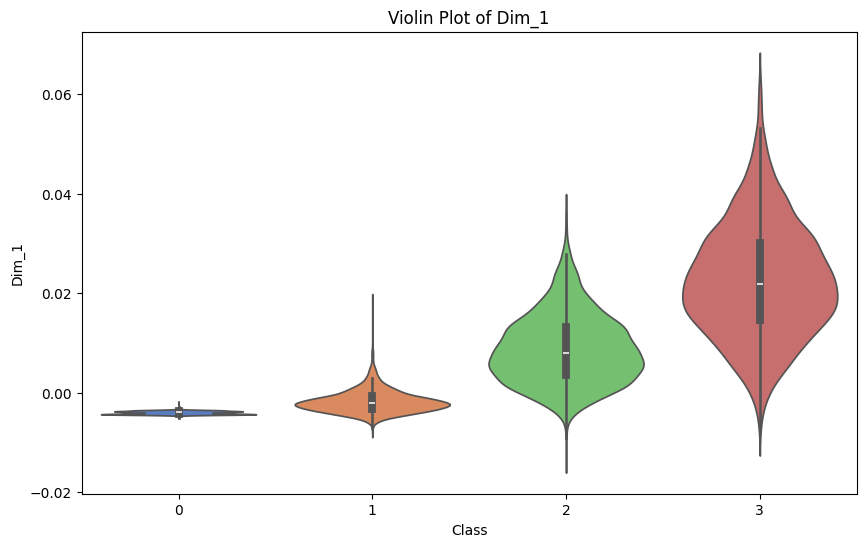

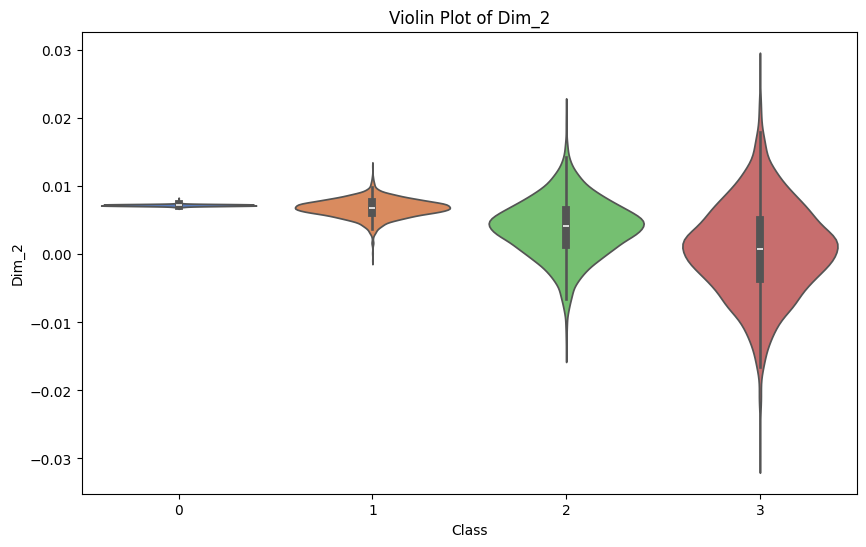

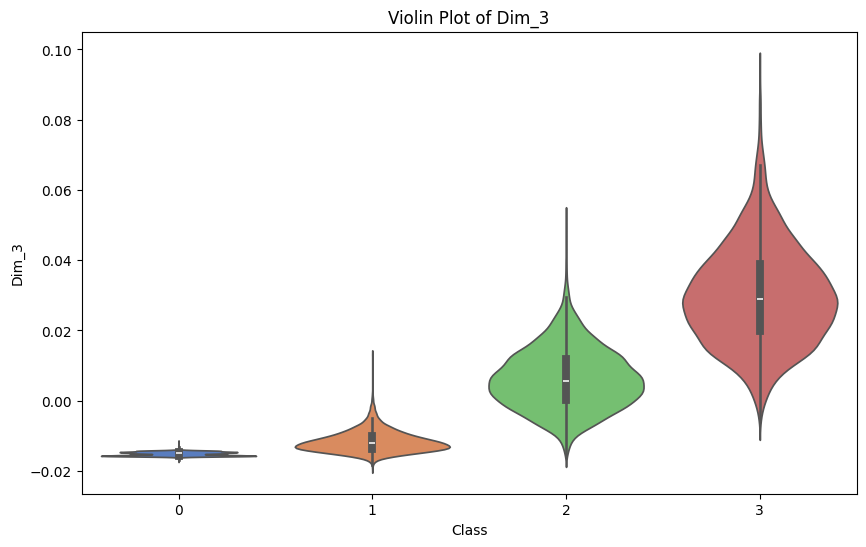

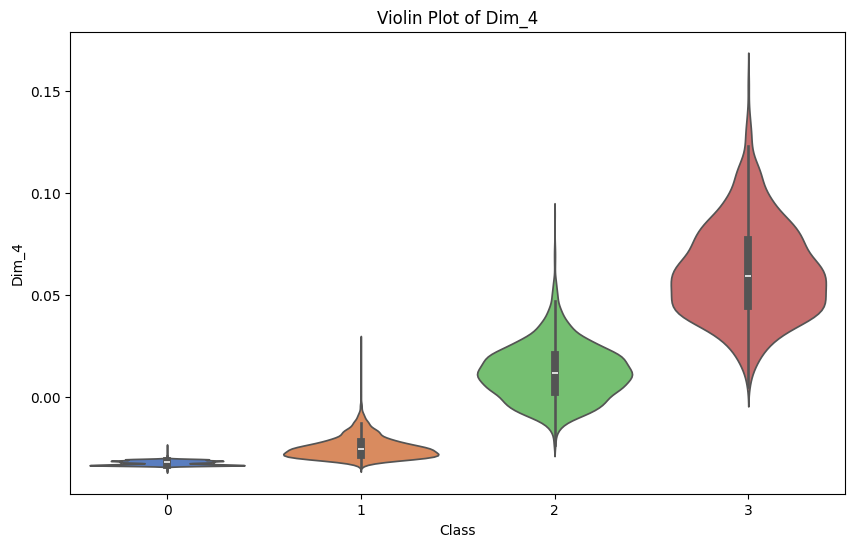

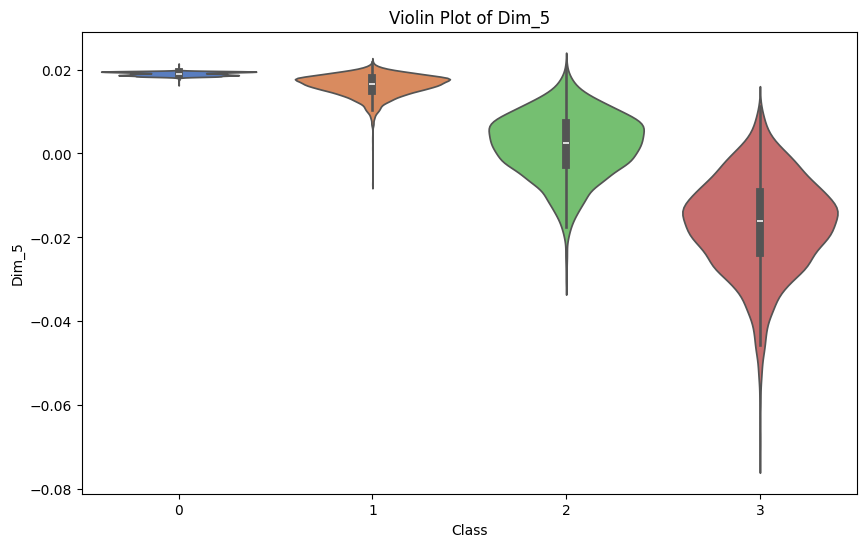

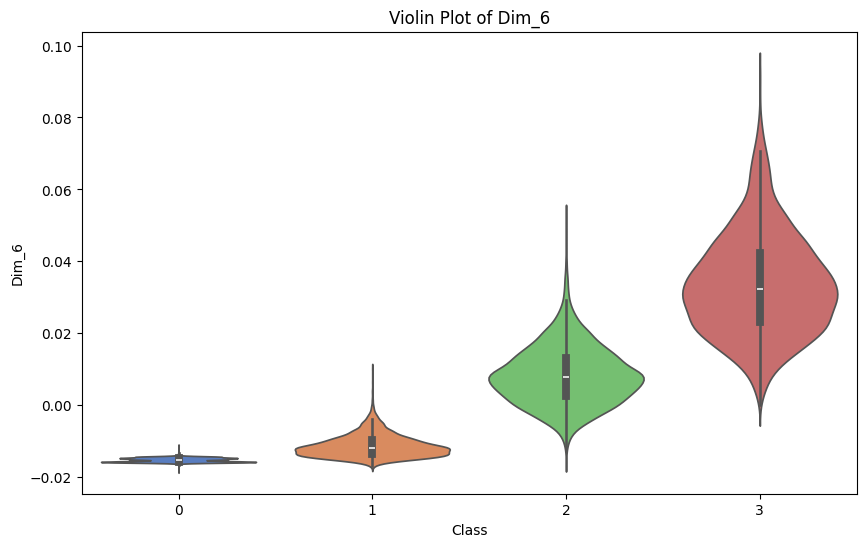

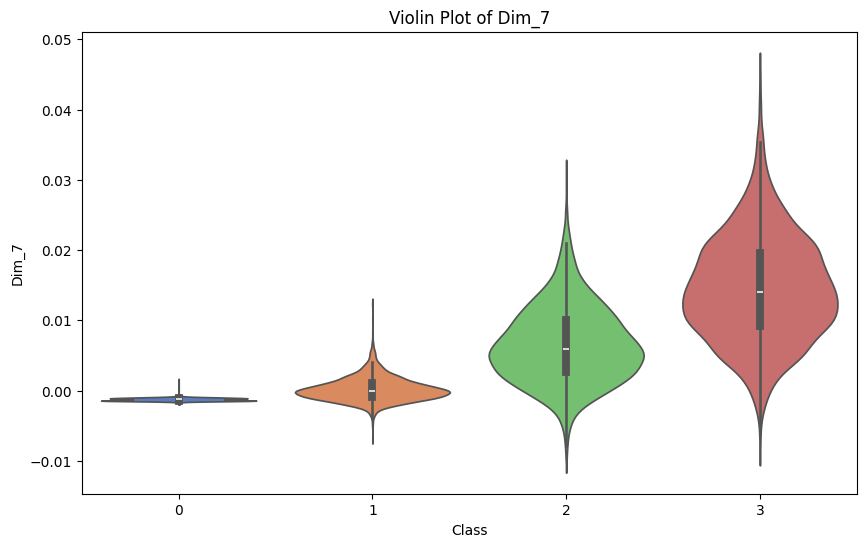

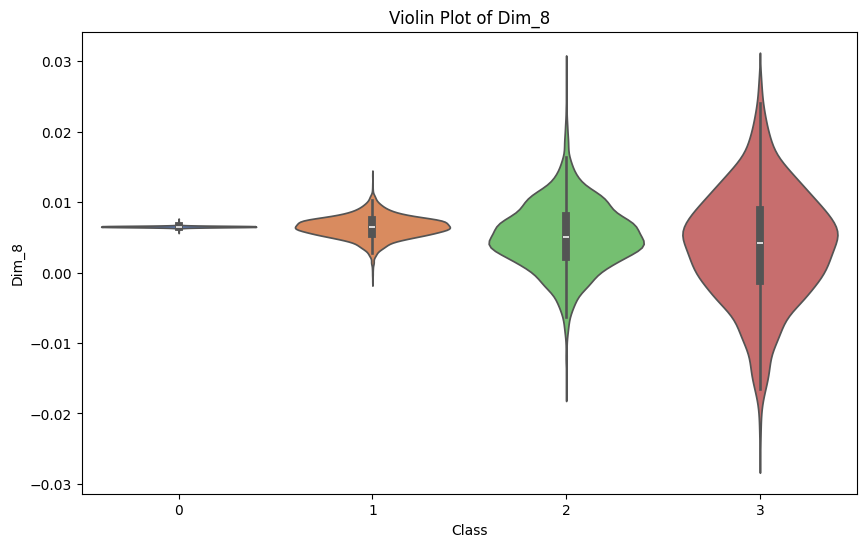

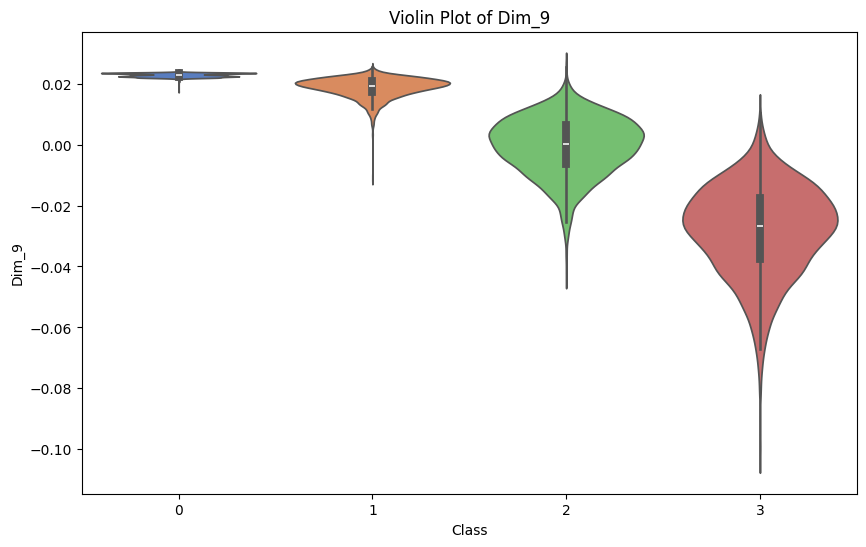

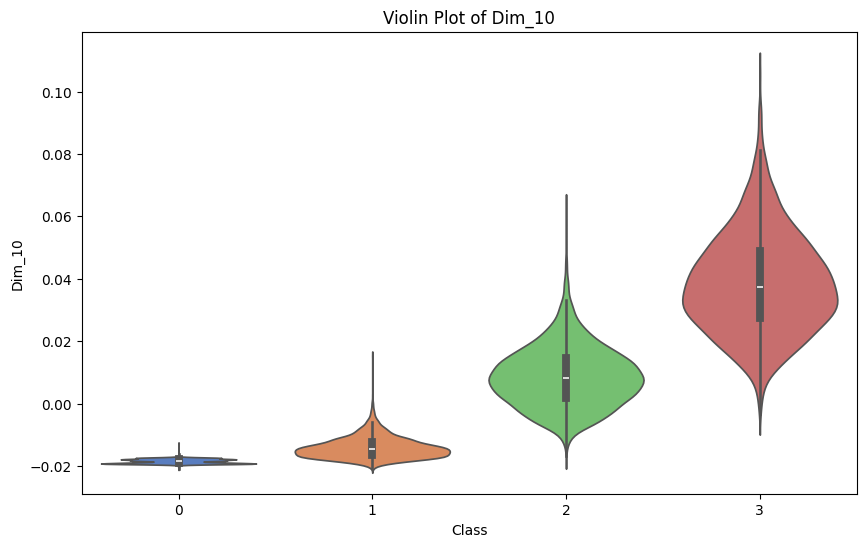

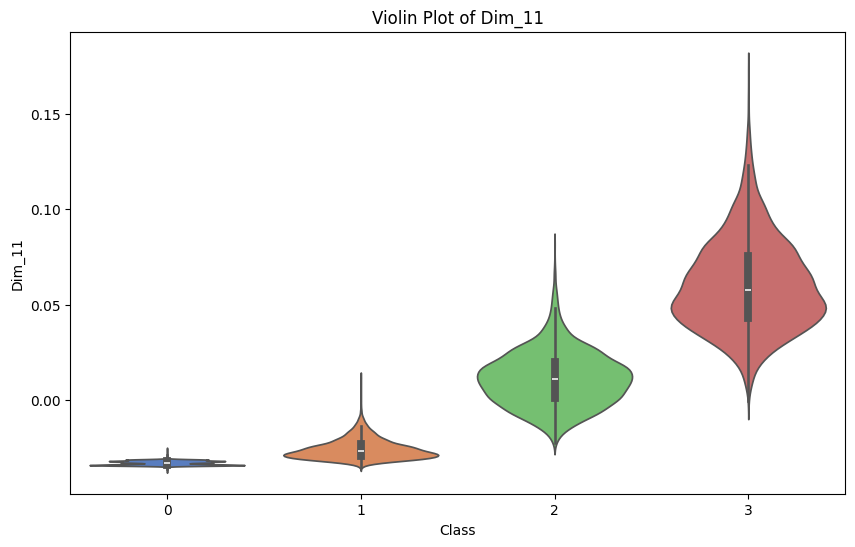

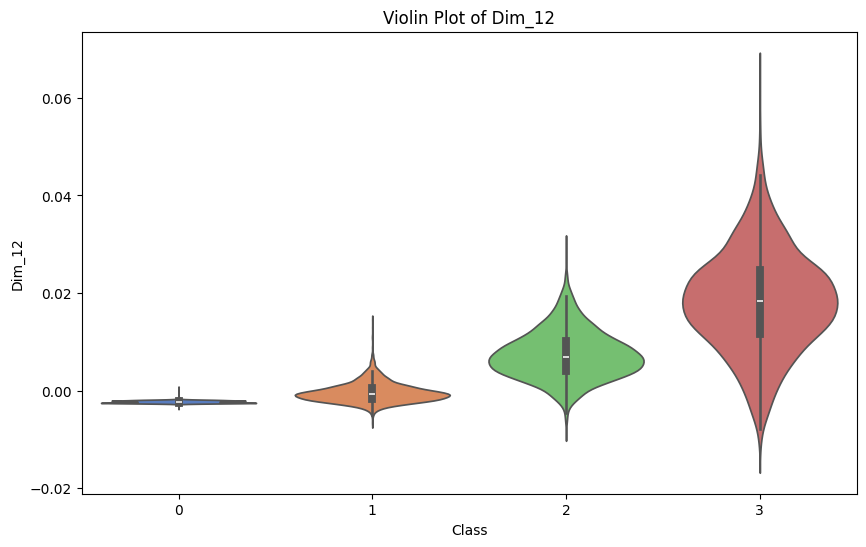

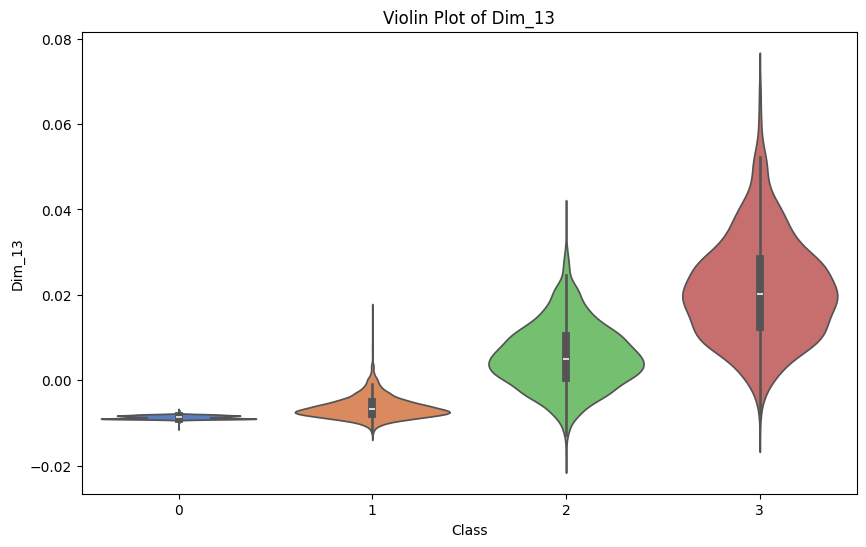

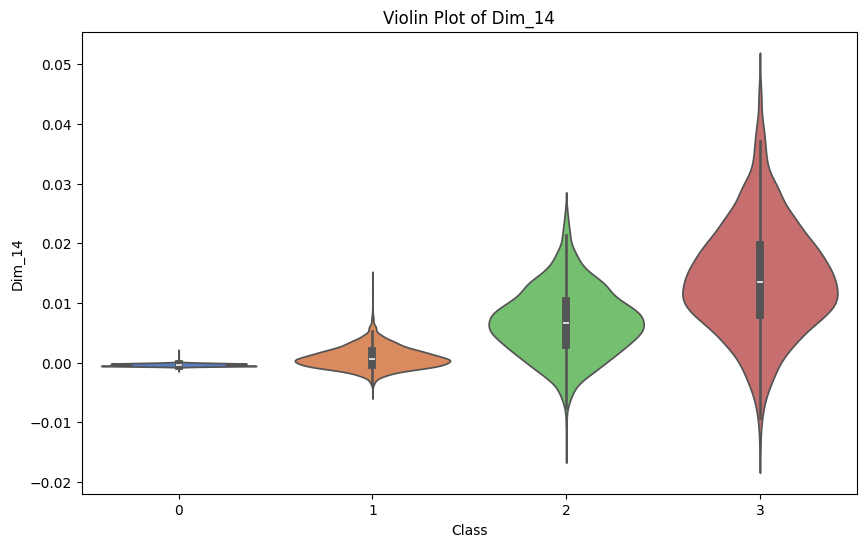

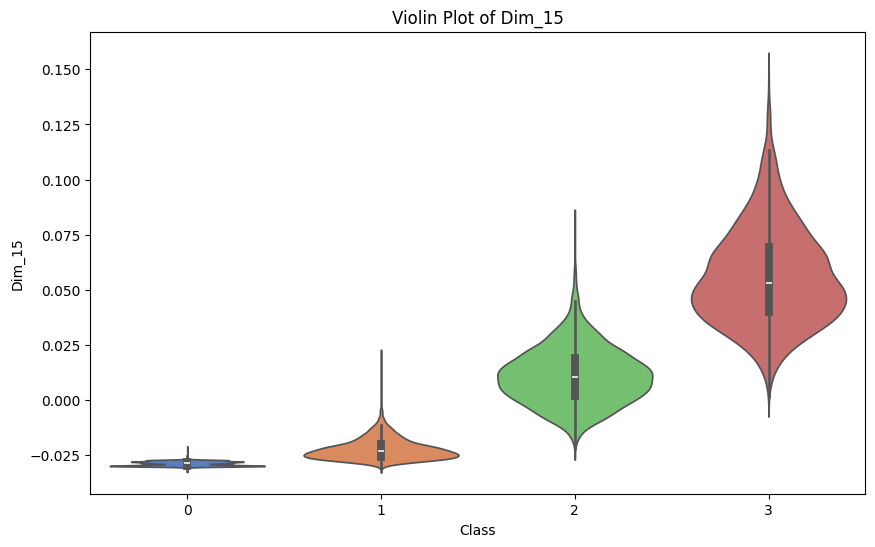

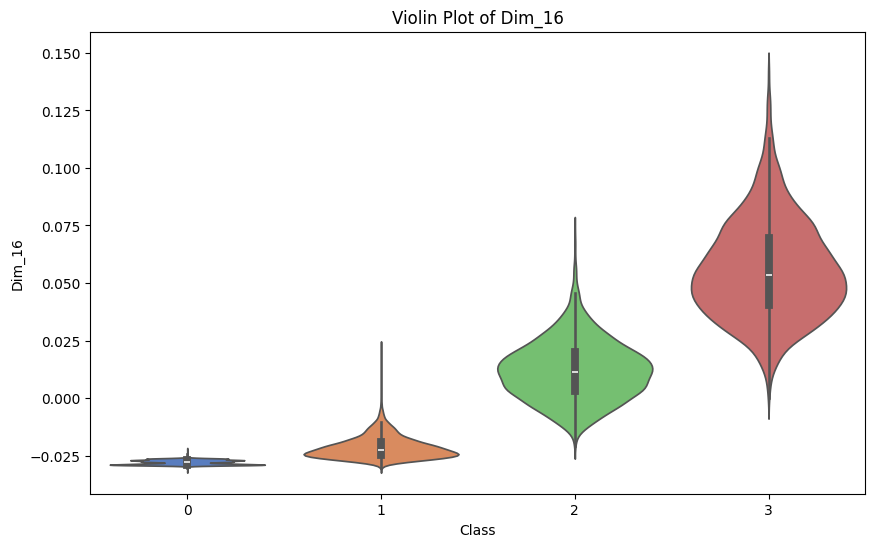

In [59]:
data = pd.DataFrame(X_train_enc, columns=[f'Dim_{i+1}' for i in range(X_train_enc.shape[1])])
data['Class'] = y_train

# Plot violin plots for each dimension
for column in data.columns[:-1]:  # Exclude the 'Class' column for the plots
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Class', y=column, data=data, hue='Class', palette='muted', legend=False)
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.show()

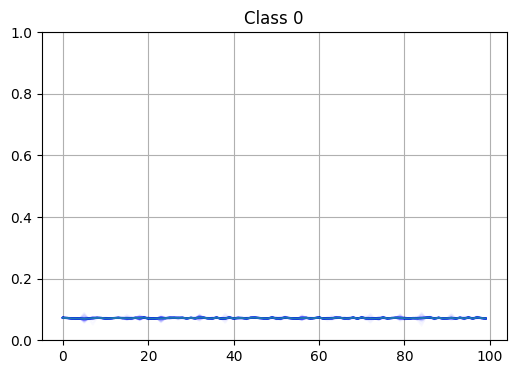

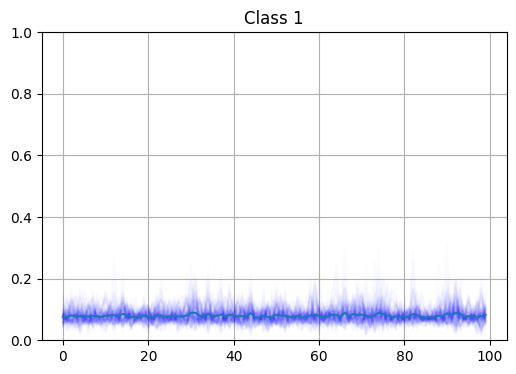

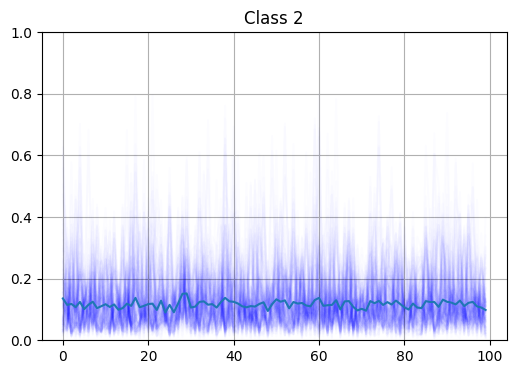

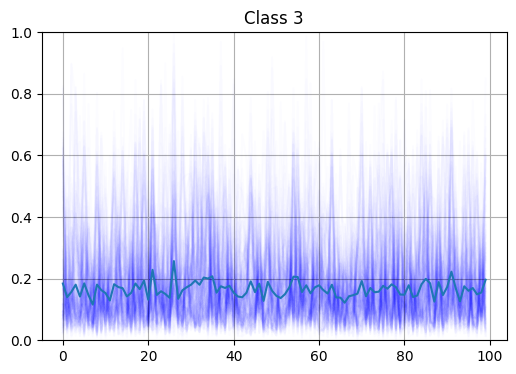

In [60]:
samples = {}
for class_label in range(4):
    indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(indices, 100)
    samples[class_label] = X_train[random_index]

for class_label, sample in samples.items():
    plt.figure(figsize=(6, 4))
    plt.plot(sample, alpha=.01, color='b')
    plt.plot(sample.mean(axis=1))
    plt.title(f"Class {class_label}")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

In [61]:
mean, std = X_train_enc.mean(), X_train_enc.std()
X_train_enc -= mean
X_train_enc /= std
X_val_enc -= mean
X_val_enc /= std

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train_enc)
y_pred = kmeans.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2118
           1       0.82      0.99      0.90     15035
           2       0.95      0.82      0.88      9923
           3       0.63      0.60      0.61      1555

    accuracy                           0.84     28631
   macro avg       0.60      0.60      0.60     28631
weighted avg       0.79      0.84      0.81     28631



In [63]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_train_enc)
y_pred = gmm.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.42      0.99      0.59      2118
           1       0.88      0.75      0.81     15035
           2       0.80      0.59      0.68      9923
           3       0.24      0.56      0.34      1555

    accuracy                           0.70     28631
   macro avg       0.59      0.72      0.61     28631
weighted avg       0.79      0.70      0.72     28631

